Iniciando simulación para el planeta Aerion...
Simulación completada. Estado: The solver successfully reached the end of the integration interval.
Número de puntos de tiempo: 28


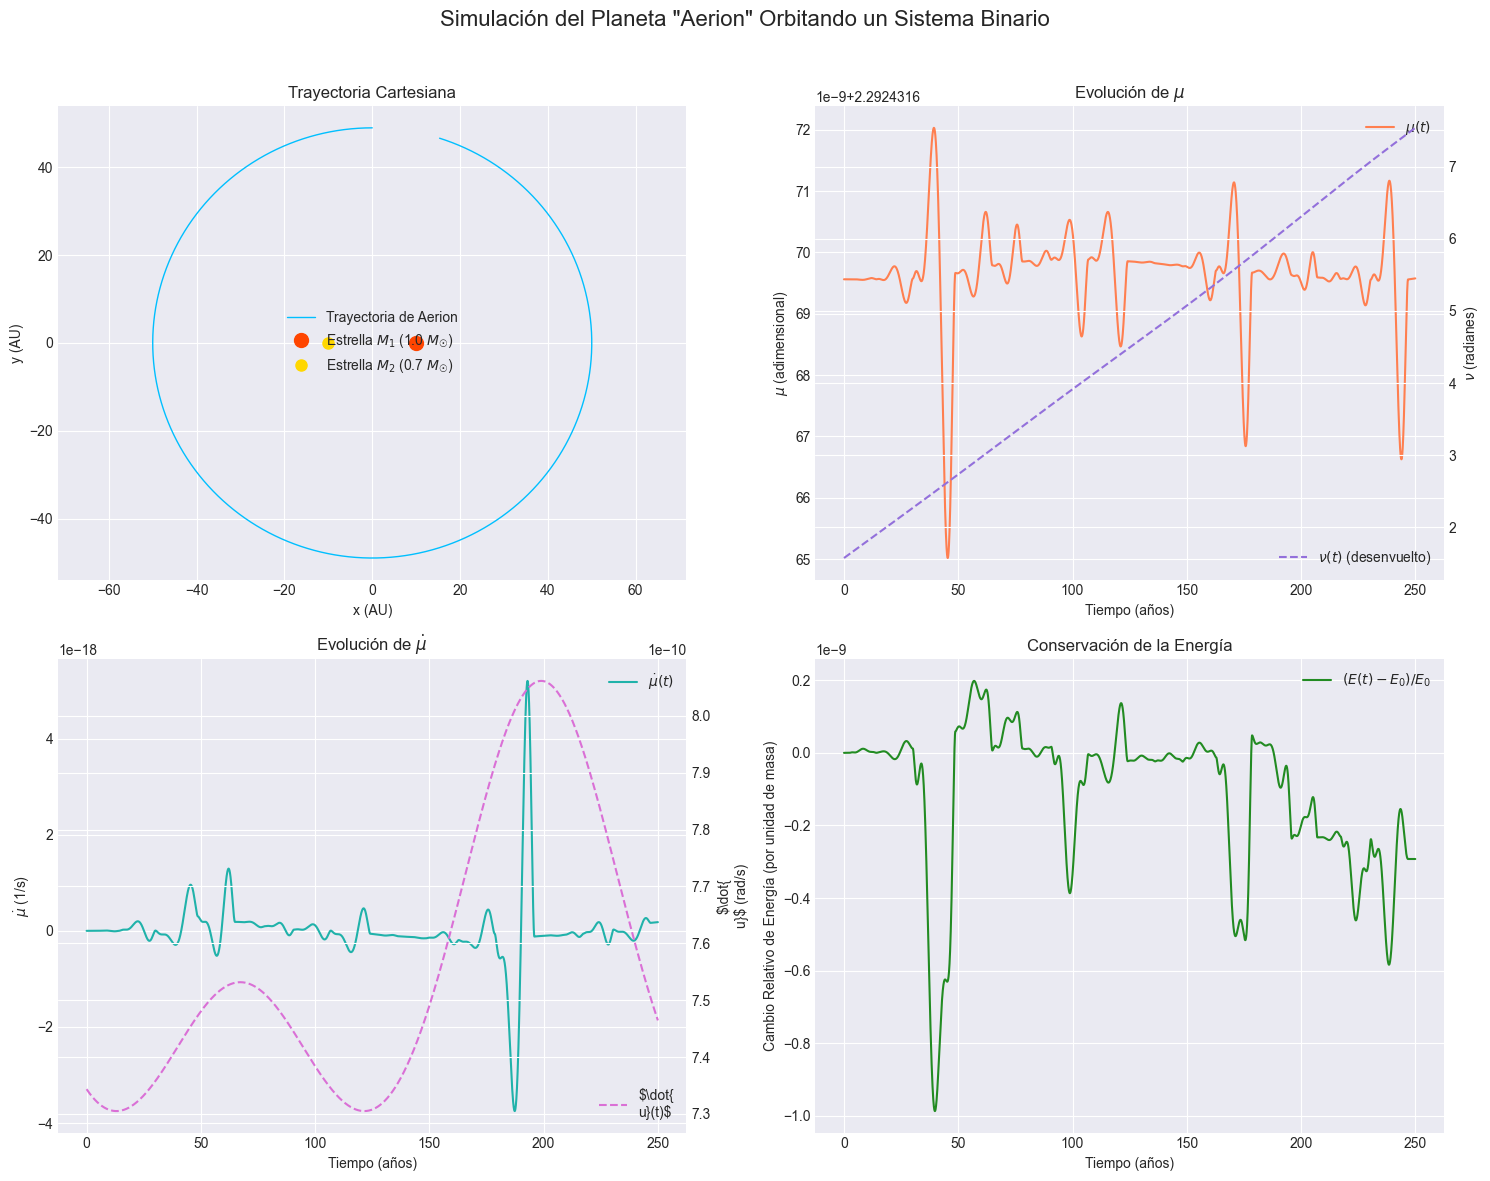

Energía inicial por unidad de masa: -1.5086e+07 J/kg
Energía final por unidad de masa: -1.5086e+07 J/kg
Cambio relativo máximo de energía: 9.87e-10


In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Constantes físicas y Unidades ---
G_CONST = 6.67430e-11  # Constante gravitacional (m^3 kg^-1 s^-2)
M_SOL = 1.989e30      # Masa del Sol (kg)
AU = 1.495978707e11   # Unidad Astronómica (m)
YEAR_S = 3.15576e7    # Un año en segundos

# --- Parámetros del Sistema Binario y Planeta "Aerion" ---
M1_stars = 1.0 * M_SOL  # Masa de la estrella 1 (kg)
M2_stars = 0.7 * M_SOL  # Masa de la estrella 2 (kg)
m_body = 6e24           # Masa del planeta "Aerion" (kg) - no influye en EOM si se divide por m_body

# Semidistancia focal 'c' (m)
# Las estrellas están en (c,0) y (-c,0) del sistema de coordenadas elípticas
# M1 en (c,0), M2 en (-c,0) según la V implementada.
c_dist_focal = 10.0 * AU

# --- Condiciones Iniciales para "Aerion" ---
# mu_0: arccosh( (Distancia media deseada) / c_dist_focal )
# Distancia media deseada (semi-eje mayor de la elipse mu=mu_0) = 50 AU
cosh_mu0 = (50.0 * AU) / c_dist_focal
mu_0 = np.arccosh(cosh_mu0)

nu_0 = np.pi / 2.0  # Posición angular elíptica inicial (sobre el eje y)
mu_dot_0 = 0.0      # Velocidad radial elíptica inicial

# Estimación de nu_dot_0 para una órbita P-type
M_total_stars = M1_stars + M2_stars
R_eff_m = c_dist_focal * np.cosh(mu_0) # Efectivamente 50 AU
# v_orb_approx_sq = G_CONST * M_total_stars / R_eff_m
# nu_dot_0_num = np.sqrt(v_orb_approx_sq) / (c_dist_focal * np.sqrt(np.cosh(mu_0)**2 - np.cos(nu_0)**2))
# Simplifica ya que cos(nu_0)=0 y sqrt(cosh^2) = cosh para mu_0 >0
nu_dot_0 = np.sqrt(G_CONST * M_total_stars / R_eff_m) / (c_dist_focal * np.cosh(mu_0))
# nu_dot_0 = 7.5569e-10 # rad/s (calculado en la explicación)

initial_conditions = [mu_0, nu_0, mu_dot_0, nu_dot_0]

# --- Parámetros de Simulación ---
t_start = 0.0
t_end = 250.0 * YEAR_S  
t_span = (t_start, t_end)
# Puntos de evaluación para una gráfica suave (solve_ivp elige los suyos para la solución)
t_eval = np.linspace(t_start, t_end, 20000)


# --- Sistema de Ecuaciones Diferenciales (Lagrangiano) ---
def derivatives_lagrangian(t, state, M1, M2, c_focal, G):
    mu, nu, mu_dot, nu_dot = state

    cosh_mu = np.cosh(mu)
    sinh_mu = np.sinh(mu)
    cos_nu = np.cos(nu)
    sin_nu = np.sin(nu)

    # Distancias a los focos (estrellas)
    # r1_denom es la distancia a M1 (en (c_focal, 0))
    # r2_denom es la distancia a M2 (en (-c_focal, 0))
    r1_val = c_focal * (cosh_mu - cos_nu)
    r2_val = c_focal * (cosh_mu + cos_nu)

    # Chequeo de colisión (denominador cero en el potencial)
    if r1_val <= 0 or r2_val <= 0:
        print(f"Advertencia: Colisión o proximidad extrema en t={t/YEAR_S:.2f} años. r1={r1_val/AU:.2f} AU, r2={r2_val/AU:.2f} AU")
        # Detener la integración devolviendo ceros (o lanzar una excepción)
        return [0,0,0,0]

    # Factor A = c^2 * (cosh^2(mu) - cos^2(nu))
    # Este factor aparece en la energía cinética y en las EOM.
    # Es c^2 * h^2 donde h es el factor de escala.
    A_factor_geom = c_focal**2 * (sinh_mu**2 + sin_nu**2) # Identidad: cosh^2(mu) - cos^2(nu) = sinh^2(mu) + sin^2(nu)
    if A_factor_geom == 0: # Singularidad de coordenadas (mu=0 y nu=0 o pi)
        print(f"Advertencia: Singularidad de coordenadas A_factor_geom = 0 en t={t/YEAR_S:.2f} años.")
        return [0,0,0,0]

    # Derivadas parciales de (L/m_body) para las EOM
    # (L/m_body) = 0.5 * A_factor_geom * (mu_dot**2 + nu_dot**2) - V/m_body
    # V/m_body = -G * (M1/r1_val + M2/r2_val)

   # d(L/m)/d(mu) = d(T/m)/d(mu) - d(V/m)/d(mu)
    dTm_dmu = c_focal**2 * sinh_mu * cosh_mu * (mu_dot**2 + nu_dot**2)
    # dVm_dmu es d(V/m)/d(mu) donde V/m = -G (M1/r1_val + M2/r2_val)
    # d(1/r1)/dmu = -1/r1_val**2 * (c_focal * sinh_mu)
    # d(1/r2)/dmu = -1/r2_val**2 * (c_focal * sinh_mu)
    # dVm_dmu = -G * (-M1 * c_focal * sinh_mu / r1_val**2 - M2 * c_focal * sinh_mu / r2_val**2)
    # dVm_dmu = G * c_focal * sinh_mu * (M1 / r1_val**2 + M2 / r2_val**2)
    _dVm_dmu_term = G * c_focal * sinh_mu * (M1 / r1_val**2 + M2 / r2_val**2) # Esta es la derivada de V/m
    dLm_dmu = dTm_dmu - _dVm_dmu_term # Correcto: d(T/m)/dmu - d(V/m)/dmu
    
    # d(L/m)/d(nu) = d(T/m)/d(nu) - d(V/m)/d(nu)
    dTm_dnu = c_focal**2 * sin_nu * cos_nu * (mu_dot**2 + nu_dot**2)
    # dVm_dnu es d(V/m)/d(nu)
    # d(1/r1)/dnu = -1/r1_val**2 * (c_focal * sin_nu)
    # d(1/r2)/dnu = -1/r2_val**2 * (-c_focal * sin_nu)
    # dVm_dnu = -G * (-M1 * c_focal * sin_nu / r1_val**2 + M2 * c_focal * sin_nu / r2_val**2)
    # dVm_dnu = G * c_focal * sin_nu * (M1 / r1_val**2 - M2 / r2_val**2)
    _dVm_dnu_term = G * c_focal * sin_nu * (M1 / r1_val**2 - M2 / r2_val**2) # Esta es la derivada de V/m
    dLm_dnu = dTm_dnu - _dVm_dnu_term # Correcto: d(T/m)/dnu - d(V/m)/dnu
    
    # ... el resto de la función para calcular mu_ddot y nu_ddot permanece igual:
    # d(A_factor_geom)/dt = 2 * c_focal**2 * (sinh_mu * cosh_mu * mu_dot + sin_nu * cos_nu * nu_dot)
    dA_factor_geom_dt = 2 * c_focal**2 * (sinh_mu * cosh_mu * mu_dot + sin_nu * cos_nu * nu_dot)
    
    mu_ddot = (dLm_dmu - dA_factor_geom_dt * mu_dot) / A_factor_geom
    nu_ddot = (dLm_dnu - dA_factor_geom_dt * nu_dot) / A_factor_geom
    
    return [mu_dot, nu_dot, mu_ddot, nu_ddot]

# --- Resolución Numérica ---
print("Iniciando simulación para el planeta Aerion...")
sol = solve_ivp(
    derivatives_lagrangian,
    t_span,
    initial_conditions,
    args=(M1_stars, M2_stars, c_dist_focal, G_CONST),
    method='DOP853', # 'RK45' es más rápido, 'DOP853' más preciso para órbitas
    dense_output=True,
    rtol=1e-9,  # Tolerancia relativa más estricta
    atol=1e-11  # Tolerancia absoluta más estricta
)
print(f"Simulación completada. Estado: {sol.message}")
print(f"Número de puntos de tiempo: {len(sol.t)}")

# Extraer resultados en los puntos de evaluación deseados
t = t_eval
mu_t = sol.sol(t)[0]
nu_t = sol.sol(t)[1]
mu_dot_t = sol.sol(t)[2]
nu_dot_t = sol.sol(t)[3]

# --- Cálculo de la Energía Total (por unidad de masa del planeta) ---
def total_energy_per_mass(mu, nu, mu_dot, nu_dot, M1, M2, c_focal, G):
    cosh_mu = np.cosh(mu)
    sinh_mu = np.sinh(mu) # Necesario para A_factor_geom
    cos_nu = np.cos(nu)
    sin_nu = np.sin(nu)   # Necesario para A_factor_geom

    A_factor_geom = c_focal**2 * (sinh_mu**2 + sin_nu**2)
    kinetic_energy_pm = 0.5 * A_factor_geom * (mu_dot**2 + nu_dot**2)

    r1_val = c_focal * (cosh_mu - cos_nu)
    r2_val = c_focal * (cosh_mu + cos_nu)
    
    potential_energy_pm = np.zeros_like(mu)
    # Evitar división por cero en el cálculo de energía también
    valid_idx = (r1_val > 0) & (r2_val > 0)
    potential_energy_pm[valid_idx] = -G * (M1 / r1_val[valid_idx] + M2 / r2_val[valid_idx])
    potential_energy_pm[~valid_idx] = np.nan # Marcar colisiones/errores

    return kinetic_energy_pm + potential_energy_pm

energy_pm_t = total_energy_per_mass(mu_t, nu_t, mu_dot_t, nu_dot_t, M1_stars, M2_stars, c_dist_focal, G_CONST)

# --- Conversión a Coordenadas Cartesianas (en AU para graficar) ---
x_t_m = c_dist_focal * np.cosh(mu_t) * np.cos(nu_t)
y_t_m = c_dist_focal * np.sinh(mu_t) * np.sin(nu_t)
x_t_au = x_t_m / AU
y_t_au = y_t_m / AU

# --- Visualización ---
plt.style.use('seaborn-v0_8-darkgrid') # Estilo de gráfico
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Simulación del Planeta "Aerion" Orbitando un Sistema Binario', fontsize=16)

# 1. Trayectoria en Coordenadas Cartesianas
axs[0, 0].plot(x_t_au, y_t_au, label='Trayectoria de Aerion', color='deepskyblue', linewidth=1)
axs[0, 0].plot(c_dist_focal / AU, 0, 'o', color='orangered', markersize=10, label=f'Estrella $M_1$ ({M1_stars/M_SOL:.1f} $M_☉$)')
axs[0, 0].plot(-c_dist_focal / AU, 0, 'o', color='gold', markersize=8, label=f'Estrella $M_2$ ({M2_stars/M_SOL:.1f} $M_☉$)')
axs[0, 0].set_xlabel('x (AU)')
axs[0, 0].set_ylabel('y (AU)')
axs[0, 0].set_title('Trayectoria Cartesiana')
axs[0, 0].legend()
axs[0, 0].axis('equal')
axs[0, 0].grid(True)

# 2. Coordenadas elípticas vs Tiempo
axs[0, 1].plot(t / YEAR_S, mu_t, label='$\mu(t)$', color='coral')
axs[0, 1].set_xlabel('Tiempo (años)')
axs[0, 1].set_ylabel('$\mu$ (adimensional)')
axs[0, 1].set_title('Evolución de $\mu$')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs_nu = axs[0, 1].twinx() # Segundo eje Y para nu
axs_nu.plot(t / YEAR_S, np.unwrap(nu_t), label='$\\nu(t)$ (desenvuelto)', color='mediumpurple', linestyle='--') # Unwrap para ver el ángulo total
axs_nu.set_ylabel('$\\nu$ (radianes)')
axs_nu.legend(loc='lower right')

# 3. Velocidades Generalizadas vs Tiempo
axs[1, 0].plot(t / YEAR_S, mu_dot_t, label='$\dot{\mu}(t)$', color='lightseagreen')
axs[1, 0].set_xlabel('Tiempo (años)')
axs[1, 0].set_ylabel('$\dot{\mu}$ (1/s)')
axs[1, 0].set_title('Evolución de $\dot{\mu}$')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs_nu_dot = axs[1, 0].twinx()
axs_nu_dot.plot(t / YEAR_S, nu_dot_t, label='$\dot{\nu}(t)$', color='orchid', linestyle='--')
axs_nu_dot.set_ylabel('$\dot{\nu}$ (rad/s)')
axs_nu_dot.legend(loc='lower right')


# 4. Energía Total (por unidad de masa) vs Tiempo
# Graficar el cambio relativo para ver mejor la conservación
initial_energy_pm = energy_pm_t[~np.isnan(energy_pm_t)][0]
relative_energy_change = (energy_pm_t - initial_energy_pm) / initial_energy_pm
axs[1, 1].plot(t / YEAR_S, relative_energy_change, label='$(E(t) - E_0)/E_0$', color='forestgreen')
axs[1, 1].set_xlabel('Tiempo (años)')
axs[1, 1].set_ylabel('Cambio Relativo de Energía (por unidad de masa)')
axs[1, 1].set_title('Conservación de la Energía')
axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Notación científica para el eje y
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar para el supertítulo
plt.show()

# Imprimir energía inicial y final para verificar
if not np.all(np.isnan(energy_pm_t)):
    print(f"Energía inicial por unidad de masa: {energy_pm_t[0]:.4e} J/kg")
    print(f"Energía final por unidad de masa: {energy_pm_t[-1]:.4e} J/kg")
    print(f"Cambio relativo máximo de energía: {np.nanmax(np.abs(relative_energy_change)):.2e}")

Producto escalar de T_mu y T_nu: 1.7791e-16


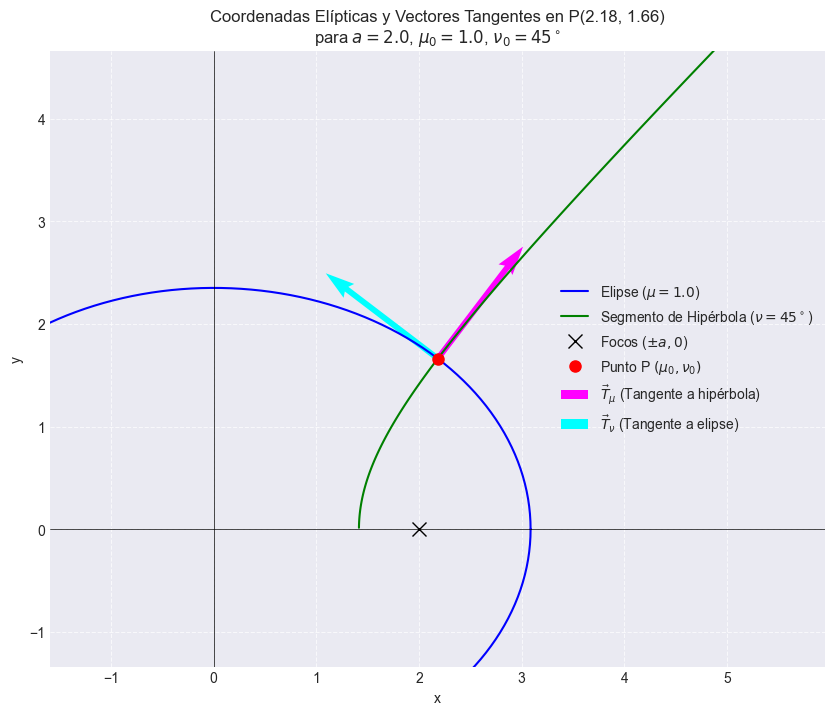

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de las coordenadas elípticas
a = 2.0  # Semidistancia focal

# Punto específico (mu_0, nu_0) para el análisis
mu_0 = 1.0
nu_0 = np.pi / 4 # 45 grados

# --- Funciones para las coordenadas y los vectores tangentes ---
def x_coord(mu, nu, a_val):
    return a_val * np.cosh(mu) * np.cos(nu)

def y_coord(mu, nu, a_val):
    return a_val * np.sinh(mu) * np.sin(nu)

# Vector tangente T_mu (derivada respecto a mu)
def T_mu_vec(mu, nu, a_val):
    dx_dmu = a_val * np.sinh(mu) * np.cos(nu)
    dy_dmu = a_val * np.cosh(mu) * np.sin(nu)
    return np.array([dx_dmu, dy_dmu])

# Vector tangente T_nu (derivada respecto a nu)
def T_nu_vec(mu, nu, a_val):
    dx_dnu = -a_val * np.cosh(mu) * np.sin(nu)
    dy_dnu = a_val * np.sinh(mu) * np.cos(nu)
    return np.array([dx_dnu, dy_dnu])

# --- Cálculos para el punto y los vectores ---
# Punto de intersección P
P_x = x_coord(mu_0, nu_0, a)
P_y = y_coord(mu_0, nu_0, a)

# Vectores tangentes en P
vec_T_mu_at_P = T_mu_vec(mu_0, nu_0, a)
vec_T_nu_at_P = T_nu_vec(mu_0, nu_0, a)

# Verificar ortogonalidad (debería ser cercano a cero debido a la precisión flotante)
dot_product = np.dot(vec_T_mu_at_P, vec_T_nu_at_P)
print(f"Producto escalar de T_mu y T_nu: {dot_product:.4e}")

# --- Preparación de datos para graficar las curvas coordenadas ---
# Curva 1: Elipse (mu = mu_0, nu varía)
nu_range = np.linspace(0, 2 * np.pi, 200)
x_ellipse = x_coord(mu_0, nu_range, a)
y_ellipse = y_coord(mu_0, nu_range, a)

# Curva 2: Hipérbola (nu = nu_0, mu varía)
# Necesitamos tener cuidado con el rango de mu para que cosh(mu) sea real y > 0
# Para una rama de la hipérbola. Si mu es muy pequeño, puede estar cerca del eje.
mu_range_positive = np.linspace(0.01, 2.5, 100) # Rama derecha/superior
mu_range_negative = np.linspace(-2.5, -0.01, 100) # Rama izquierda/inferior (simétrica si se define x para mu<0)
# Para nuestra definición (cosh(mu)), mu >= 0 es lo usual.
# Si quisiéramos ambas ramas de la hipérbola para un nu fijo, necesitaríamos parametrizar
# o considerar el significado de mu negativo. Con la parametrización usual mu >=0.
# Para ver la forma hiperbólica, podemos graficar para un rango de mu.

x_hyperbola_branch1 = x_coord(mu_range_positive, nu_0, a)
y_hyperbola_branch1 = y_coord(mu_range_positive, nu_0, a)

# Para la otra rama de la hipérbola (si nu_0 está en (0, pi)), podemos usar nu_0 + pi
# o reflejar. Alternativamente, si x = c sec(theta), y = k tan(theta)
# Aquí vamos a graficar solo la rama correspondiente a nu_0 y mu_range_positive.
# Si quisieramos la otra rama de la hipérbola que pasa por el mismo nu (pero no necesariamente por el mismo punto (mu_0, nu_0)),
# podríamos tomar -mu, pero cosh(-mu)=cosh(mu) y sinh(-mu)=-sinh(mu).
# O considerar el rango completo de nu para las hipérbolas.

# Mejor, para la hipérbola que pasa por (mu_0, nu_0), variamos mu alrededor de mu_0
# y si se quiere extender, considerar las dos ramas.
# La hipérbola completa para un nu fijo tiene dos ramas.
# x^2 / (a cos(nu_0))^2 - y^2 / (a sin(nu_0))^2 = cosh^2(mu) - sinh^2(mu) = 1 (si nu_0 no es 0 o pi/2)
# Si nu_0 = pi/4, x^2/(a*cos(pi/4))^2 - y^2/(a*sin(pi/4))^2 = 1
# x_hyperbola_full_nu = np.concatenate((np.flip(x_coord(mu_range_positive, nu_0 + np.pi, a)), x_coord(mu_range_positive, nu_0, a)))
# y_hyperbola_full_nu = np.concatenate((np.flip(y_coord(mu_range_positive, nu_0 + np.pi, a)), y_coord(mu_range_positive, nu_0, a)))

# Simplifiquemos: graficaremos un segmento de la hipérbola que pasa por el punto
mu_hyper_segment = np.linspace(max(0.01, mu_0-1), mu_0+1, 100)
x_hyperbola_segment = x_coord(mu_hyper_segment, nu_0, a)
y_hyperbola_segment = y_coord(mu_hyper_segment, nu_0, a)


# --- Graficación ---
plt.figure(figsize=(10, 8))
# Curvas coordenadas
plt.plot(x_ellipse, y_ellipse, label=f'Elipse ($\mu = {mu_0:.1f}$)', color='blue')
plt.plot(x_hyperbola_segment, y_hyperbola_segment, label=f'Segmento de Hipérbola ($\\nu = {nu_0*180/np.pi:.0f}^\\circ$)', color='green')

# Focos (para referencia)
plt.plot([-a, a], [0, 0], 'kx', markersize=10, label='Focos ($\pm a, 0$)')


# Punto P
plt.plot(P_x, P_y, 'o', color='red', markersize=8, label=f'Punto P $(\mu_0, \\nu_0)$')

# Vectores tangentes (escalados para visualización)
scale_factor = 0.5 # Para que no sean demasiado largos en la gráfica
plt.quiver(P_x, P_y, vec_T_mu_at_P[0], vec_T_mu_at_P[1],
           angles='xy', scale_units='xy', scale=1/scale_factor, color='magenta',
           label='$\\vec{T}_\\mu$ (Tangente a hipérbola)')
plt.quiver(P_x, P_y, vec_T_nu_at_P[0], vec_T_nu_at_P[1],
           angles='xy', scale_units='xy', scale=1/scale_factor, color='cyan',
           label='$\\vec{T}_\\nu$ (Tangente a elipse)')


plt.title(f'Coordenadas Elípticas y Vectores Tangentes en P({P_x:.2f}, {P_y:.2f})\n'
          f'para $a={a}$, $\mu_0={mu_0}$, $\\nu_0={nu_0*180/np.pi:.0f}^\\circ$')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.axis('equal') # Muy importante para que la ortogonalidad se vea correctamente
plt.xlim(P_x - 3*a*scale_factor, P_x + 3*a*scale_factor) # Ajustar límites para mejor visualización
plt.ylim(P_y - 3*a*scale_factor, P_y + 3*a*scale_factor)
plt.show()

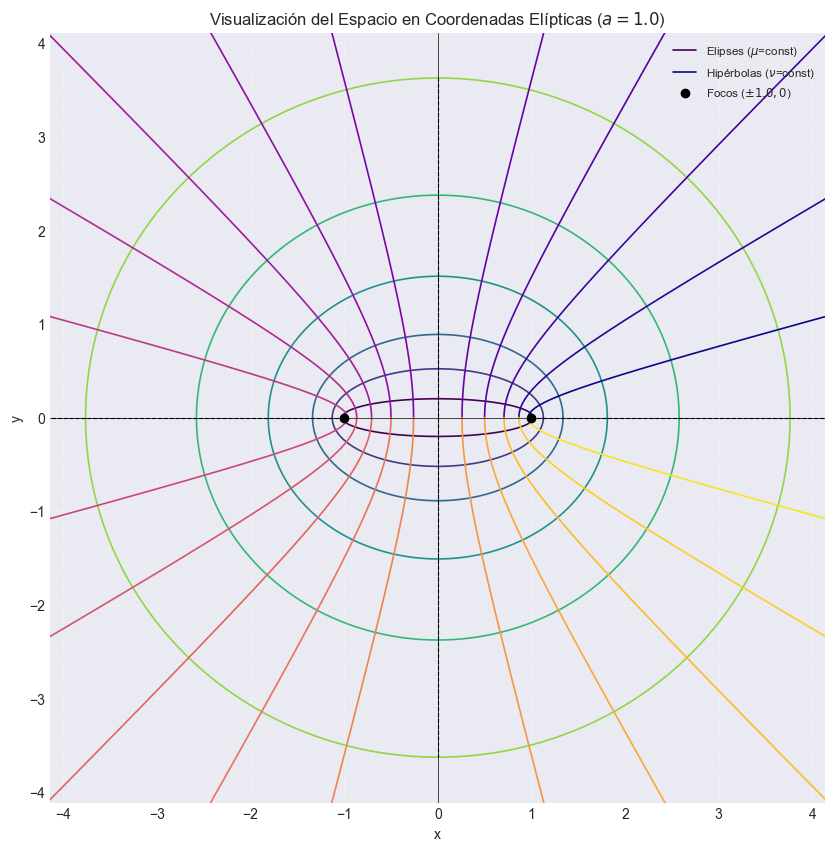

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetro 'a' (semidistancia focal)
a = 1.0

# --- Funciones para las coordenadas elípticas ---
def x_coord(mu, nu, a_val):
    return a_val * np.cosh(mu) * np.cos(nu)

def y_coord(mu, nu, a_val):
    return a_val * np.sinh(mu) * np.sin(nu)

# --- Preparación de la figura ---
plt.figure(figsize=(10, 10))
ax = plt.gca() # Get current axes

# --- Dibujar las curvas mu = constante (elipses) ---
# Valores de mu para las elipses. mu >= 0.
# mu=0 es la línea entre los focos. Empezamos con mu > 0 para elipses no degeneradas.
mu_values = np.array([0.2, 0.5, 0.8, 1.2, 1.6, 2.0])
nu_range_ellipse = np.linspace(0, 2 * np.pi, 200) # nu varía de 0 a 2*pi

for i, mu_val in enumerate(mu_values):
    x_ellipse = x_coord(mu_val, nu_range_ellipse, a)
    y_ellipse = y_coord(mu_val, nu_range_ellipse, a)
    # Usar un degradado de color o colores distintos
    color_ellipse = plt.cm.viridis(i / len(mu_values))
    ax.plot(x_ellipse, y_ellipse, color=color_ellipse, linewidth=1.2, label=f"$\mu={mu_val:.1f}$" if i==0 else None)

# --- Dibujar las curvas nu = constante (hipérbolas) ---
# Valores de nu para las hipérbolas. Consideramos nu en [0, 2*pi).
# Para evitar duplicados visuales y cubrir las formas, podemos tomar nu en [0, pi]
# y luego usar simetrías o extender el rango.
# O más fácil: tomar valores espaciados en [0, 2*pi)
# Cada nu constante da una rama de hipérbola cuando mu > 0.
num_hyperbolas_half = 8 # Número de hipérbolas a dibujar en [0, pi)
# nu_values = np.linspace(0, 2*np.pi, num_hyperbolas_half * 2, endpoint=False)

# Seleccionamos algunos valores de nu para mostrar claramente las ramas
# Evitamos nu=0, pi/2, pi, 3pi/2 donde las hipérbolas degeneran en los ejes.
nu_angles_deg = np.array([15, 30, 45, 60, 75, 105, 120, 135, 150, 165,
                          180+15, 180+30, 180+45, 180+60, 180+75,
                          180+105, 180+120, 180+135, 180+150, 180+165])
nu_values = np.deg2rad(nu_angles_deg)


# mu varía desde un valor pequeño (no cero para evitar la singularidad en y para algunas nu)
# hasta un valor que defina bien la forma de la hipérbola.
mu_range_hyperbola = np.linspace(0.001, 2.5, 100)

for i, nu_val in enumerate(nu_values):
    x_hyperbola = x_coord(mu_range_hyperbola, nu_val, a)
    y_hyperbola = y_coord(mu_range_hyperbola, nu_val, a)
    # Usar un degradado de color o colores distintos
    color_hyperbola = plt.cm.plasma(i / len(nu_values))
    ax.plot(x_hyperbola, y_hyperbola, color=color_hyperbola, linewidth=1.2, label=f"$\\nu={np.rad2deg(nu_val):.0f}^\\circ$" if i==0 else None)

# Añadir las líneas de los ejes (que son casos degenerados de hipérbolas)
# Eje x (fuera de los focos): nu=0 y nu=pi
mu_axis = np.linspace(a, np.cosh(mu_values.max()) * a + 1, 100) # mu > 0 para cosh(mu)>1
x_axis_pos = x_coord(np.arccosh(mu_axis/a), 0, a) # mu_axis = a*cosh(mu) => mu = arccosh(mu_axis/a)
y_axis_pos = np.zeros_like(x_axis_pos)
ax.plot(x_axis_pos, y_axis_pos, 'k--', linewidth=0.8)
ax.plot(-x_axis_pos, y_axis_pos, 'k--', linewidth=0.8) # nu=pi

# Eje y: nu=pi/2 y nu=3*pi/2
mu_for_y_axis = np.linspace(0.001, mu_values.max(), 100)
x_yaxis = np.zeros_like(mu_for_y_axis)
y_yaxis = y_coord(mu_for_y_axis, np.pi/2, a)
ax.plot(x_yaxis, y_yaxis, 'k--', linewidth=0.8)
ax.plot(x_yaxis, -y_yaxis, 'k--', linewidth=0.8) # nu=3*pi/2


# Marcar los focos
ax.plot([-a, a], [0, 0], 'ko', markersize=6, label=f'Focos ($\pm {a}, 0$)')

# --- Configuración de la gráfica ---
ax.set_title(f'Visualización del Espacio en Coordenadas Elípticas ($a={a}$)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(True, linestyle=':', alpha=0.6)
ax.axis('equal') # Esencial para ver la ortogonalidad

# Ajustar límites para una mejor visualización
max_coord_x = a * np.cosh(mu_values.max()) * 1.1
max_coord_y = a * np.sinh(mu_values.max()) * 1.1
ax.set_xlim([-max_coord_x, max_coord_x])
ax.set_ylim([-max_coord_y, max_coord_y])

# Crear una leyenda combinada si hay muchas curvas
handles, labels = [], []
# Para las elipses (tomar la primera etiqueta)
if mu_values.size > 0:
    line_el = ax.get_lines()[0] # Asumiendo que las elipses se graficaron primero
    handles.append(line_el)
    labels.append(f"Elipses ($\mu$=const)")

# Para las hipérbolas (tomar la primera etiqueta de hipérbola)
if nu_values.size > 0:
    # Encontrar la primera línea que no sea elipse o eje
    idx_first_hyperbola = len(mu_values)
    line_hyp = ax.get_lines()[idx_first_hyperbola]
    handles.append(line_hyp)
    labels.append(f"Hipérbolas ($\\nu$=const)")

# Focos
foci_artist = ax.collections[0] if ax.collections else ax.get_lines()[-1] # El último punto o línea
# Si usaste 'ko' para los focos, son Line2D.
if ax.lines: # Asegurarse de que hay líneas para tomar la de los focos
    # Asumiendo que los focos es la última línea añadida con 'ko'
    # O buscarla por label
    for line in ax.lines:
        if line.get_label() == f'Focos ($\pm {a}, 0$)':
            foci_artist = line
            break
    handles.append(foci_artist)
    labels.append(foci_artist.get_label())


ax.legend(handles=handles, labels=labels, loc='upper right', fontsize='small')

plt.show()